In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import numpy as np
import tensorflow as tf
from keras import datasets, models, layers 
import time
from matplotlib import pyplot as plt

2024-07-05 13:55:35.397180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 13:55:35.397288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 13:55:35.525712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
(X_train, _), (X_test, _ ) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [4]:
X_train.shape
X_test.shape

(50000, 32, 32, 3)

(10000, 32, 32, 3)

In [5]:
def subplt (rows, cols, img):
  plt_img = img[:rows*cols]
  for i in range(len(plt_img)):
    plt.subplot(rows, cols, i+1)
    plt.imshow(plt_img[i], cmap = 'gray')
    plt.axis('off')
  
  return

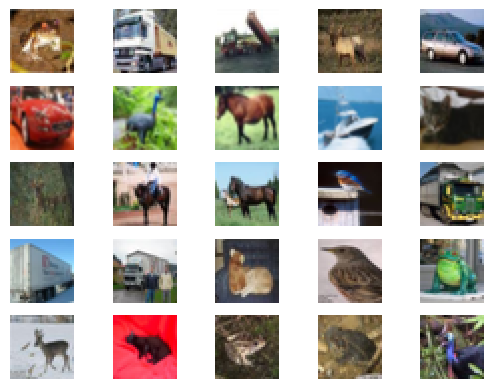

In [6]:
subplt(5,5,X_train)

In [7]:
X_train.max()

255

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
noise_factor = 0.007

# Example reshaping for noise addition
X_train_noise = X_train + noise_factor * np.random.normal(loc=0, scale=1.0, size=X_train.shape)
X_test_noise = X_test + noise_factor * np.random.normal(loc=0, scale=1.0, size=X_test.shape)

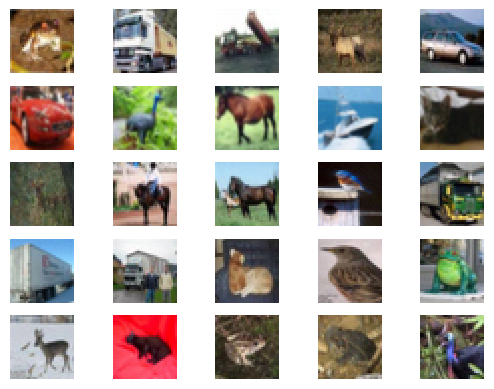

In [10]:
subplt(5,5,X_train_noise)

In [11]:
X_train = X_train.reshape(X_train.shape[0],32,32,3)
X_test = X_test.reshape(X_test.shape[0],32,32,3)
X_train_noise = X_train_noise.reshape(X_train_noise.shape[0],32,32,3)
X_test_noise = X_test_noise.reshape(X_test_noise.shape[0],32,32,3)

## Creating Autoencoder Model

In [12]:
from tensorflow.keras import layers, models

input_shape = (32,32,3)
input_layer = layers.Input(shape=input_shape, name='Input_Layer')

# Encoder
x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)
encoded_layer = layers.MaxPooling2D((2, 2), name='Encoded_Layer')(x)

# Decoder
x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_uniform')(encoded_layer)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)

decoded_layer = layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', activation='sigmoid', kernel_initializer='he_uniform', name='Decoded_Layer')(x)

# Output
output_layer = decoded_layer
dae = models.Model(inputs=input_layer, outputs=output_layer, name='dae-cifar10')

dae.summary()

Model: "dae-cifar10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoded_Layer (MaxPooling2D)    │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 2, 2, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoded_Layer (Conv2DTranspose) │ (None, 32, 32, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,334,787 (5.09 MB)

 Trainable params: 1,333,123 (5.09 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [13]:
dae.compile(optimizer = 'adam', loss = 'mse')

In [14]:
epochs = 50
batch_size = 256

# Start time measurement
start = time.time()

# Training loop
history = dae.fit(
    x=X_train_noise, y=X_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test_noise, X_test),
    verbose=1
)

# Calculate and print time consumed
print(f"Time consumed = {time.time()-start} seconds")

Epoch 1/50
  7/196 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2010

I0000 00:00:1720187783.808529      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 0.0604 - val_loss: 0.0292
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0217 - val_loss: 0.0190
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0179 - val_loss: 0.0177
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0147 - val_loss: 0.0146
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0140 - val_loss: 0.0148
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0129 - val_loss: 0.0199
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0146 - val_loss: 0.0130
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0125 - val_loss: 0.0130
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 12/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/st

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Loss (epochs=50, batch_size=256)')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

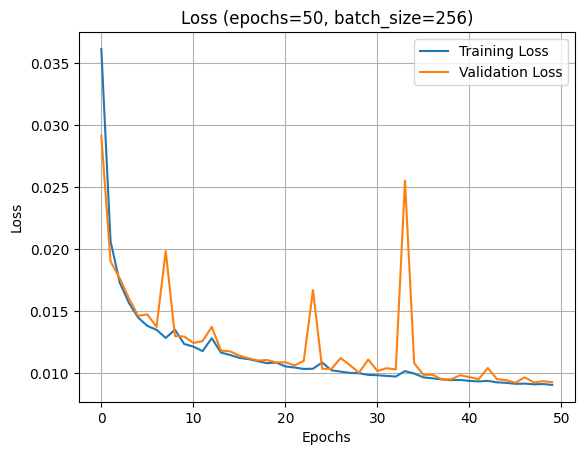

In [15]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f"Loss (epochs={epochs}, batch_size={batch_size})")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
dae.save("DAE-CIFAR10.h5")

In [17]:
encoder = models.Model(inputs = input_layer, outputs = encoded_layer)
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoded_Layer (MaxPooling2D)    │ (None, 1, 1, 256)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,352 (1.42 MB)

 Trainable params: 371,584 (1.42 MB)

 Non-trainable params: 768 (3.00 KB)

In [18]:
decoder = models.Model(inputs = encoded_layer, outputs = decoded_layer)
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ keras_tensor_7CLONE             │ (None, 1, 1, 256)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 2, 2, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoded_Layer (Conv2DTranspose) │ (None, 32, 32, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 962,435 (3.67 MB)

 Trainable params: 961,539 (3.67 MB)

 Non-trainable params: 896 (3.50 KB)

## Testing model on testing data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


<Figure size 600x1800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Noisy')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generative Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Noisy')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generative Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Noisy')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generative Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Noisy')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generative Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Noisy')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generative Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Noisy')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generative Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Noisy')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generative Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Noisy')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generative Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Noisy')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Original Denoised')

(-0.5, 31.5, 31.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Generative Denoised')

(-0.5, 31.5, 31.5, -0.5)

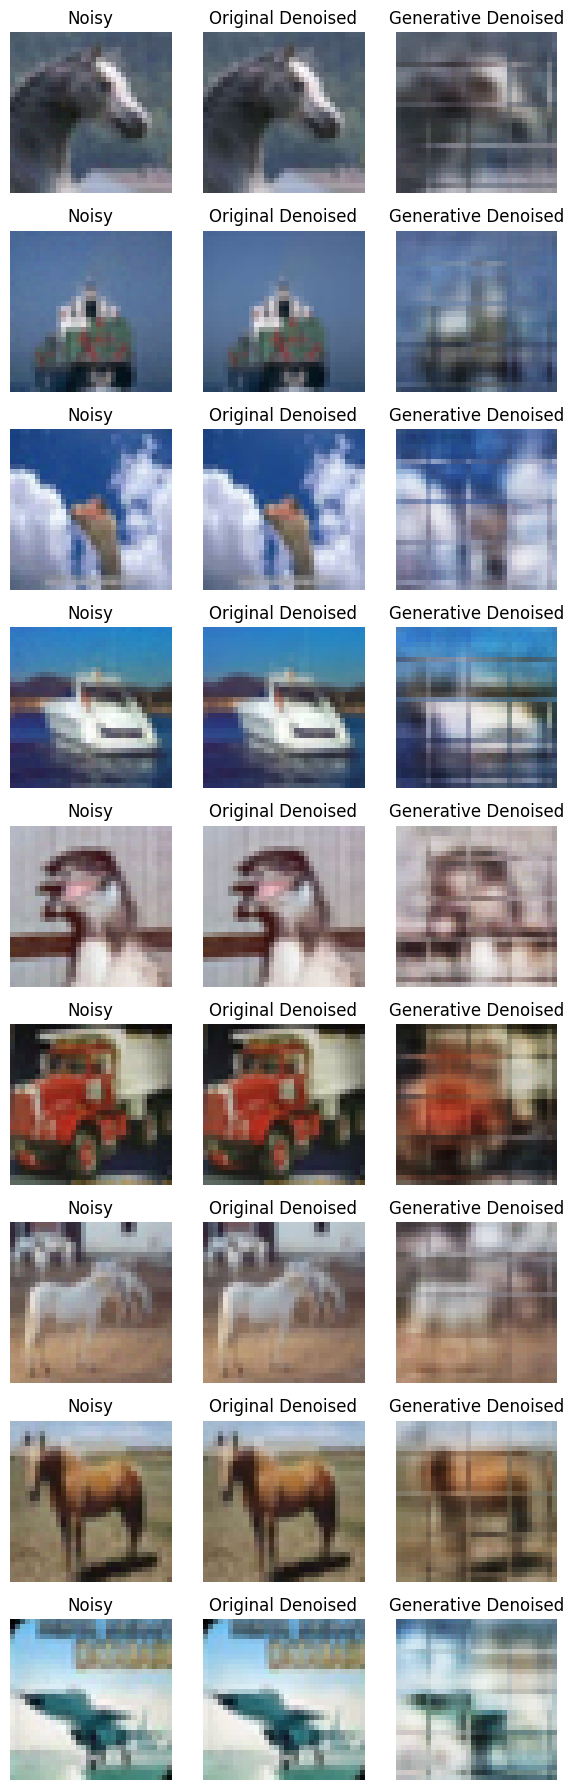

In [19]:
rows = 9
cols = 3

indices = np.random.randint(0, len(X_test_noise), rows)

test_noise_images = X_test_noise[indices]
test_images = X_test[indices]

encoded_imgs = encoder.predict(test_noise_images)
reconstructed_images = decoder.predict(encoded_imgs)

plt.figure(figsize=(cols*2, rows*2))

for i in range(len(indices)):
    # Noisy image
    plt.subplot(rows, cols, 3*i + 1)
    plt.imshow(test_noise_images[i].reshape(32, 32,3))
    plt.title('Noisy')
    plt.axis('off')

    # Original denoised image
    plt.subplot(rows, cols, 3*i + 2)
    plt.imshow(test_images[i].reshape(32, 32,3))
    plt.title('Original Denoised')
    plt.axis('off')

    # Reconstructed image
    plt.subplot(rows, cols, 3*i + 3)
    plt.imshow(reconstructed_images[i].reshape(32, 32,3))
    plt.title('Generative Denoised')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error

test_noise = X_test_noise.reshape(X_test_noise.shape[0],-1)
test = X_test.reshape(X_test.shape[0],-1)

encoded = encoder.predict(X_test_noise)
pred = decoder.predict(encoded)
pred = pred.reshape(pred.shape[0],-1)

mse = mean_squared_error(test,pred)
print(f"mse = {mse}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
mse = 0.009293154331055764
